# Hamiltonian Simulation by QEVT
The goal of Hamiltonian simulation is to simulate the time evolution of a state $\ket{\psi}$ under a Hamiltonian $\mathcal{H}$. From the Schrödinger equation we know that:
$$
i \hslash \dfrac{d}{dt} \ket{\psi(t)} = \mathcal{H} \ket{\psi(t)}
$$
which has the solution:
$$
\ket{\psi(t)} = e^{-i \mathcal{H} t / \hslash}
$$
where we can set $\hslash = 1$.

Thus, we want to approximate the time evolution function $e^{-i \mathcal{H} t}$ for a given Hamiltonian $\mathcal{H}$ at a certian time $t$. It is therefore just a function approximation problem that can be solved using the QEVT. While it would be natural to assume to just approximate the exponential function, this cannot be done as it is not symmetric. However, we can use Euler's formula to decompose it into sine and cosine functions and approximate these instead.

In [92]:
# Importing the necessary libraries
import numpy as np
from numpy import pi
from scipy.linalg import expm, sinm, cosm, sqrtm
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import *
from qiskit import Aer
from qiskit.circuit.library.standard_gates import XGate, MCXGate
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Importing pyqsp
import pyqsp
from pyqsp.angle_sequence import QuantumSignalProcessingPhases

# Importing QSVT notebook
%%capture
%run QSVT.ipynb

UsageError: Line magic function `%%capture` not found.


15.537708063830353
R=7
[PolySineTX] rescaling by 0.5.


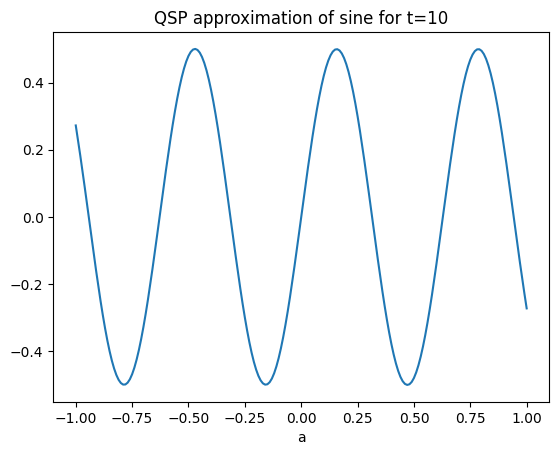

In [93]:
pg = pyqsp.poly.PolySineTX()
sin_pcoeffs, scale = pg.generate(10, 0.1, ensure_bounded=True, return_scale=True)
poly_filt = np.polynomial.Polynomial(sin_pcoeffs)
poly_filt.degree()

ang_seq_sin_QSP = QuantumSignalProcessingPhases(sin_pcoeffs, signal_operator="Wz")
d = len(ang_seq_sin_QSP) - 1
ang_seq_sin_QEVT = ang_seq_sin_QSP - phase_diff(d)

a_list = np.linspace(-1, 1, 201)
plt.title("QSP approximation of sine for t=10")
plt.xlabel("a")
plt.plot(a_list, poly_filt(a_list), label="polynomial")

15.537708063830353
R=7
[PolyCosineTX] rescaling by 0.5.


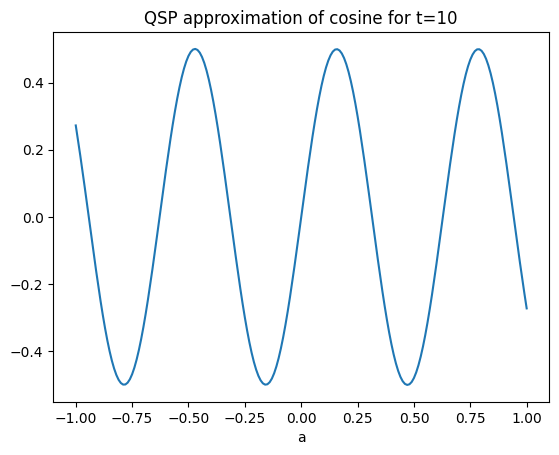

In [94]:
pg = pyqsp.poly.PolyCosineTX()
cos_pcoeffs, scale = pg.generate(10, 0.1, ensure_bounded=True, return_scale=True)
poly_filt = np.polynomial.Polynomial(sin_pcoeffs)
poly_filt.degree()

ang_seq_cos_QSP = QuantumSignalProcessingPhases(cos_pcoeffs, signal_operator="Wz")
d = len(ang_seq_cos_QSP) - 1
ang_seq_cos_QEVT = ang_seq_cos_QSP - phase_diff(d)

a_list = np.linspace(-1, 1, 201)
plt.title("QSP approximation of cosine for t=10")
plt.xlabel("a")
plt.plot(a_list, poly_filt(a_list), label="polynomial")

In [95]:
def QEVT_gate(phi_vec, H):
    QEVT_matrix = QEVT(phi_vec, H)
    QEVT_gate = UnitaryGate(QEVT_matrix, label="U")

    nqubits = int(np.log2(U.shape[0]))
    q = QuantumRegister(nqubits, 'q')
    QEVT_circuit = QuantumCircuit(q)
    QEVT_circuit.append(QEVT_gate, q)
    
    return QEVT_circuit

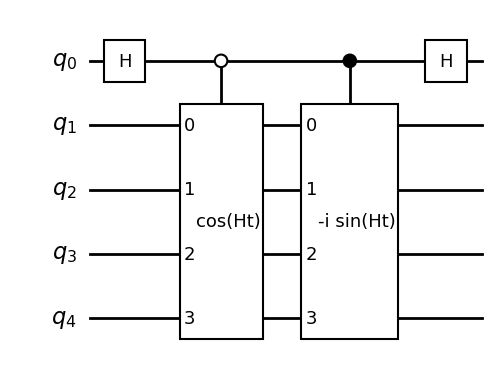

In [96]:
# create QEVT sine gate
qc_sin = QEVT_gate(ang_seq_sin_QEVT, H)
# add phase gate
qc_sin.p(theta=0.5*np.pi * ((len(ang_seq_sin_QEVT)-1)), qubit=0)
qc_sin.p(theta=-0.5*np.pi, qubit=0)
QEVT_sin_gate = qc_sin.to_gate(label="-i sin(Ht)").control(1, ctrl_state='1')

# create QEVT cosine gate
qc_cos = QEVT_gate(ang_seq_cos_QEVT, H)
qc_cos.p(theta=0.5*np.pi * ((len(ang_seq_cos_QEVT)-1)), qubit=0)
QEVT_cos_gate = qc_sin.to_gate(label="cos(Ht)").control(1, ctrl_state='0')

# create circuit for Hamiltonian simulation
nqubits = int(np.log2(U.shape[0])) + 1
H_sim_circ = QuantumCircuit(nqubits)
H_sim_circ.h(0)
H_sim_circ.append(QEVT_cos_gate, [0,1,2,3,4])
H_sim_circ.append(QEVT_sin_gate, [0,1,2,3,4])
H_sim_circ.h(0)
H_sim_circ.draw('mpl', style="bw")

In [97]:
def get_matrix(circ):
    """
    Takes a qiskit circuit and returns the corresponding matrix
    """
    backend = Aer.get_backend('unitary_simulator')
    job = execute(circ, backend)
    result = job.result()
    matrix = np.array(result.get_unitary(circ, decimals=15))
    return matrix

In [98]:
matrix = get_matrix(H_sim_circ)[0:8, 0:8]
expected = expm(-10j*H)
print(np.linalg.norm(matrix - expected))

2.900182786977447


In [99]:
array_to_latex(matrix.real, prefix="\\text{Circuit = }\n")

<IPython.core.display.Latex object>

In [100]:
array_to_latex(expected.real, prefix="e^{-10 i \mathcal{H}} = \n")

<IPython.core.display.Latex object>

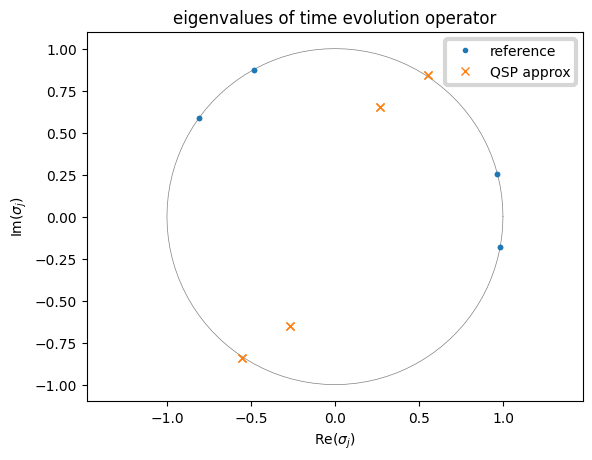

In [102]:
σU_ref = np.linalg.eigvals(expected)
σU = np.linalg.eigvals(matrix)
plt.plot([np.cos(2*np.pi*x) for x in np.linspace(0, 1, 101)], [np.sin(2*np.pi*x) for x in np.linspace(0, 1, 101)], color="gray", linewidth=0.5)
plt.plot(σU_ref.real, σU_ref.imag, '.', label="reference")
plt.plot(4*σU.real, 4*σU.imag, 'x', label="QSP approx")
plt.xlabel(r"$\mathrm{Re}(\sigma_j)$")
plt.ylabel(r"$\mathrm{Im}(\sigma_j)$")
plt.axis("equal")
plt.title("eigenvalues of time evolution operator")
plt.legend()
plt.show()